In [59]:
import pandas as pd
import geopandas as gpd
import datetime
import numpy as np
from shapely.geometry import Point, LineString
import shapely.wkt
import matplotlib.pyplot as plt
%matplotlib inline

#doc on accelerometer
# http://www.starlino.com/imu_guide.html

## Load original data

In [2]:
#phone info
f = open('../data/SEQ_0/track.txt','r')
phone = f.readline()
print 'phone info:',phone
f.close()



phone info: motorola Moto G (4);7.0;1.1.6;2.0.10;photo



In [40]:
photos = pd.read_csv('../data/SEQ_1/track.txt',sep=';',
                   skiprows=[0],
                   skipfooter=1,
                     usecols=[0,15],
                   header=None,
                   engine = 'python')
photos.columns = ['timestamp','photo']
photos = photos.loc[~(photos['photo'].isnull()),:]
photos.head()

,timestamp,photo
4491,1.494902e+09,0.0
5630,1.494902e+09,1.0
6245,1.494902e+09,2.0
7128,1.494902e+09,3.0
7737,1.494902e+09,4.0


In [44]:
photos['timestamp'][4491]

1494901712.3900001

In [53]:
#read original data from file within track.txt.gz used by OSC to store sensor data
data = pd.read_csv('../data/SEQ_1/track.txt',sep=';',
                   skiprows=[0],
                   skipfooter=1,
                   usecols=[0,1,2,3,4,5,9,10,11,16,17,18],
                   header=None,
                   engine = 'python')

#naming of columns 
names = ['timestamp','long','lat','elevation','horizontal_accu',
         'GPSspeed','accelerationX','accelerationY','accelerationZ',
         'gravityX','gravityY','gravityZ'
        ]

data.columns=names

data.head()


,timestamp,long,lat,elevation,horizontal_accu,GPSspeed,accelerationX,accelerationY,accelerationZ,gravityX,gravityY,gravityZ
0,1.494902e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.494902e+09,NaN,NaN,NaN,NaN,NaN,-0.012438,0.003953,-0.006077,NaN,NaN,NaN
2,1.494902e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.148694,0.845168,0.513401
3,1.494902e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.494902e+09,NaN,NaN,NaN,NaN,NaN,-0.012438,0.003953,-0.006077,NaN,NaN,NaN


In [54]:
#conversion into timestamp
dates = []
for i in range(data.shape[0]):
    try:
        dates.append(datetime.datetime.fromtimestamp(data['timestamp'].iloc[i]))
    except :
        print 'Error with row:', i
data['timestamp'] = dates        
data.head()

,timestamp,long,lat,elevation,horizontal_accu,GPSspeed,accelerationX,accelerationY,accelerationZ,gravityX,gravityY,gravityZ
0,2017-05-15 22:28:20.497406,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-05-15 22:28:20.497364,NaN,NaN,NaN,NaN,NaN,-0.012438,0.003953,-0.006077,NaN,NaN,NaN
2,2017-05-15 22:28:20.497339,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.148694,0.845168,0.513401
3,2017-05-15 22:28:20.507680,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017-05-15 22:28:20.507618,NaN,NaN,NaN,NaN,NaN,-0.012438,0.003953,-0.006077,NaN,NaN,NaN


In [55]:
#remove all empty rows except timestamp
emtpy = data.iloc[:,1:].isnull().sum(axis=1) == data.shape[1]-1
data = data.loc[~emtpy,:]
data.index=range(data.shape[0])

data.head()

,timestamp,long,lat,elevation,horizontal_accu,GPSspeed,accelerationX,accelerationY,accelerationZ,gravityX,gravityY,gravityZ
0,2017-05-15 22:28:20.497364,NaN,NaN,NaN,NaN,NaN,-0.012438,0.003953,-0.006077,NaN,NaN,NaN
1,2017-05-15 22:28:20.497339,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.148694,0.845168,0.513401
2,2017-05-15 22:28:20.507618,NaN,NaN,NaN,NaN,NaN,-0.012438,0.003953,-0.006077,NaN,NaN,NaN
3,2017-05-15 22:28:20.507593,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.148694,0.845168,0.513401
4,2017-05-15 22:28:20.517672,NaN,NaN,NaN,NaN,NaN,-0.012438,0.003953,-0.006077,NaN,NaN,NaN


In [56]:
#short sample of data with gps data in teh extremes
#data from 49 to 451 with 250 in the middle
#choose long lat and acc data
#calcular la distancia euclidiana


#dataClip = data.loc[49:451,['long','lat','accelerationX','accelerationY','accelerationZ']]
#dataClip.dropna(axis=0,how='all',inplace=True)
#dataClip.to_csv('testcase.csv',index_label=False)
#dataClip.head()

In [57]:
dataClip = data.loc[:,['long','lat','accelerationX','accelerationY','accelerationZ']]
dataClip.dropna(axis=0,how='all',inplace=True)
dataClip.head()

,long,lat,accelerationX,accelerationY,accelerationZ
0,NaN,NaN,-0.012438,0.003953,-0.006077
2,NaN,NaN,-0.012438,0.003953,-0.006077
4,NaN,NaN,-0.012438,0.003953,-0.006077
6,NaN,NaN,-0.012438,0.003953,-0.006077
8,NaN,NaN,-0.012438,0.003953,-0.006077


## Geography

In [8]:
print 'GPS data points for clip data:'
gpsDataPoints =  dataClip.loc[~ (dataClip['long'].isnull()),['long','lat']]
gpsDataPoints['pointIndex'] = gpsDataPoints.index
gpsDataPoints.head()

GPS data points for clip data:


,long,lat,pointIndex
136,-74.000973,40.695163,136
341,-74.000974,40.695165,341
546,-74.000975,40.695166,546
825,-74.000982,40.695163,825
1216,-74.000986,40.695160,1216


In [9]:
geometry = []
for i in range(len(gpsDataPoints.index)):
    if i == (len(gpsDataPoints.index)-1):
        line = np.nan
    else:
        #get start and end points for each line
        startPoint = Point(gpsDataPoints['long'].loc[gpsDataPoints.index[i]], gpsDataPoints['lat'].loc[gpsDataPoints.index[i]])
        endPoint = Point(gpsDataPoints['long'].loc[gpsDataPoints.index[i+1]], gpsDataPoints['lat'].loc[gpsDataPoints.index[i+1]])
        #convert to shapely wkt
        line = LineString([startPoint,endPoint]).wkt
        geometry.append(shapely.wkt.loads(line))




In [10]:
gpsDataPoints = gpsDataPoints.iloc[:-1]
crs = {'init': 'epsg:4326'}
gpsDataPoints = gpd.GeoDataFrame(gpsDataPoints, crs=crs, geometry=geometry)
gpsDataPoints.head()

,long,lat,pointIndex,geometry
136,-74.000973,40.695163,136,"LINESTRING (-74.00097323999999 40.69516347, -7..."
341,-74.000974,40.695165,341,"LINESTRING (-74.00097396 40.69516531, -74.0009..."
546,-74.000975,40.695166,546,"LINESTRING (-74.00097519000001 40.69516573, -7..."
825,-74.000982,40.695163,825,"LINESTRING (-74.00098247 40.69516282, -74.0009..."
1216,-74.000986,40.695160,1216,"LINESTRING (-74.00098647 40.69515984, -74.0009..."


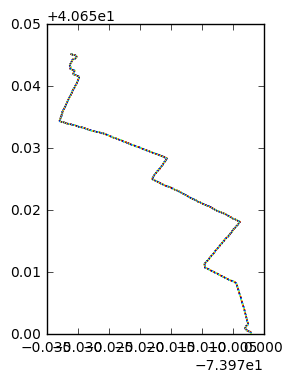

In [11]:
gpsDataPoints.plot()

## Total vector from XYZ

In [12]:
dataClip = dataClip.merge(gpsDataPoints.drop(['geometry'],axis=1),how='left')
dataClip.head()

,long,lat,accelerationX,accelerationY,accelerationZ,pointIndex
0,NaN,NaN,-0.012438,0.003953,-0.006077,NaN
1,NaN,NaN,-0.012438,0.003953,-0.006077,NaN
2,NaN,NaN,-0.012438,0.003953,-0.006077,NaN
3,NaN,NaN,-0.012438,0.003953,-0.006077,NaN
4,NaN,NaN,-0.012438,0.003953,-0.006077,NaN


In [13]:
dataClip['pointIndex'] = dataClip['pointIndex'].fillna(method='ffill')
dataClip.head()

,long,lat,accelerationX,accelerationY,accelerationZ,pointIndex
0,NaN,NaN,-0.012438,0.003953,-0.006077,NaN
1,NaN,NaN,-0.012438,0.003953,-0.006077,NaN
2,NaN,NaN,-0.012438,0.003953,-0.006077,NaN
3,NaN,NaN,-0.012438,0.003953,-0.006077,NaN
4,NaN,NaN,-0.012438,0.003953,-0.006077,NaN


In [14]:
dataClipShifted = dataClip.shift(1)
dataClipShifted.drop(['long','lat','pointIndex'],axis=1,inplace=True)
dataClipShifted.columns = ['accelerationXShift','accelerationYShift','accelerationZShift']
dataClip = pd.concat([dataClip,dataClipShifted],axis=1)
dataClip.drop(['long','lat'],axis=1,inplace=True)
dataClip.dropna(axis=0,how='any',inplace=True)

dataClipShifted.head()

,accelerationXShift,accelerationYShift,accelerationZShift
0,NaN,NaN,NaN
1,-0.012438,0.003953,-0.006077
2,-0.012438,0.003953,-0.006077
3,-0.012438,0.003953,-0.006077
4,-0.012438,0.003953,-0.006077


## Calculating vector

$ (x_1 -x_1lag)^2 +  (y_1 - y_1lag)^2 + (z_1 - z_1lag)^2 $

In [15]:
dataClip['V'] = np.sqrt((dataClip.accelerationX-dataClip.accelerationXShift) ** 2 + \
    #(dataClip.accelerationY-dataClip.accelerationYShift) ** 2 + \
    (dataClip.accelerationZ-dataClip.accelerationZShift) ** 2)

In [16]:
vectorInformation = dataClip.loc[:,['pointIndex','V']].groupby(by=['pointIndex']).sum()
vectorInformation.head()

,V
pointIndex,
136.0,1.042762
341.0,0.748889
546.0,0.750211
825.0,0.955072
1216.0,1.398042


In [17]:
vectorInformation.reset_index(inplace=True)
#apply the square root to the sum
vectorInformation.head()

,pointIndex,V
0,136.0,1.042762
1,341.0,0.748889
2,546.0,0.750211
3,825.0,0.955072
4,1216.0,1.398042


In [18]:
gpsDataPoints = gpsDataPoints.merge(vectorInformation)

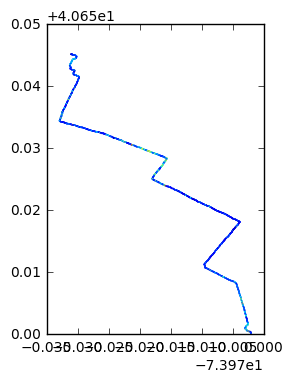

In [19]:
gpsDataPoints.plot(column='V')

In [ ]:
#centroids

In [20]:
gpsDataPoints.to_file('../shapes/SEQ_1')